In [ ]:
!date

In [ ]:
pwd

In [71]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ants
from tqdm import tqdm

In [49]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform
    vec = inVec
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
                   
    mat = squareform(pdist(vec,metric=metric).transpose())
    if data_scale=='ordinal':
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]
    return triu_vec


In [4]:
indir = '../Data/020-fmriprepped/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii')
#cf_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF.nii')
#gm_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_GM.nii')
cf_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF-strict.nii')
gm_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_GM-strict.nii')
brain_mask = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')

subs = [sub for sub in subs_orig if all(( 
    os.path.exists(epi_fn.format(sub=sub,r=1)),
    os.path.exists(epi_fn.format(sub=sub,r=2)),
    os.path.exists(cf_fn.format(sub=sub)),
    os.path.exists(gm_fn.format(sub=sub)),
    os.path.exists(brain_mask.format(sub=sub)),
    ))]

subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

34/34


In [86]:
corr_resid_cf = []
corr_data_cf = []
for s in tqdm(range(34)):
    r = 1
    sub = subs[s]
    print(sub)
    
    epi = ants.image_read(epi_fn.format(sub=sub,r=r))
    #epi = ants.image_read(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','COMPCORR_bold.nii'))
    gm = ants.image_read(gm_fn.format(sub=sub))
    brain = ants.image_read(brain_mask.format(sub=sub))
    cf = ants.image_read(cf_fn.format(sub=sub))
    
    nt = epi.shape[-1] # Number of timepoints
    ndummy = 8 # how many dummies to discard
    
    epi_flat = epi.numpy().reshape(-1,nt).transpose() # (370, 1082035)
    epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
    epi_flat = epi_flat.transpose()
    gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
    cf_flat = cf.numpy().flatten().astype(int) # (1082035,)
    assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Check for overlap again
    
    
    ### Motion Censoring
    do_censor_frames=True
    if do_censor_frames:
        import pandas as pd
        mot_fn = f'../Data/020-fmriprepped/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv'
        mot = pd.read_csv(mot_fn,delimiter='\t')
        mot_outliers = mot['framewise_displacement'].values>.2
        mot_outliers = np.vstack((mot_outliers,np.hstack((False,mot_outliers[0:-1])),np.hstack((mot_outliers[1::],False)))).sum(axis=0)>0
        outlier_idx = np.nonzero(mot_outliers)[0]
        
        #plt.figure(figsize=(15,5))
        #plt.subplot(1,2,1)
        #plt.plot(mot['framewise_displacement'].values)
        #plt.plot(mot_outliers,'r.')
        
        #plt.subplot(1,2,2)
        #plot_vec = epi_flat[gm_flat==1,:][5000,:]
        #outlier_idx = np.nonzero(mot_outliers)[0]
        #plt.plot(plot_vec)
        #plt.plot(outlier_idx,plot_vec[outlier_idx],'r.')
        
        #plot_vec[mot_outliers] = plot_vec[~mot_outliers].mean()
        #plt.plot(plot_vec)
        
        epi_flat[:,mot_outliers] = epi_flat[:,~mot_outliers].mean(axis=1)[:,np.newaxis]
    
    func_gm = epi_flat[gm_flat==1,:]
    func_cf = epi_flat[cf_flat==1,:]
    
    
    from nilearn.glm.first_level import make_first_level_design_matrix
    import pandas as pd
    events_fn = f'../Data/010-Data_bids2/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv'
    events = pd.read_csv(events_fn,delimiter='\t')
    
    t_r = 0.8  # repetition time is 1 second
    n_scans = epi_flat.shape[1]  # the acquisition comprises 128 scans
    frame_times = (np.arange(n_scans) * t_r)
    
    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
    
    face_reg = X1[['0_back_neutface','2_back_neutface','0_back_negface','2_back_negface','0_back_posface','2_back_posface',]].values.sum(axis=1)
    place_reg = X1[['0_back_place','2_back_place']].values.sum(axis=1)
    
    ffa_im = ants.image_read('../Misc/ffa_mask_resampled.nii')
    func_ffa = func_gm[ffa_im.numpy().flatten()[gm_flat==1]==1,:]
    
    
    from sklearn.decomposition import PCA
    from sklearn import linear_model
    
    X = face_reg[:,np.newaxis]
    Y = func_ffa.transpose()
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(X,Y);
    
    predicted = lin_reg.predict(X)
    residuals = Y-predicted
    
    corr_resid_cf.append( np.corrcoef(residuals.mean(axis=-1),func_cf.mean(axis=0))[0,1] )
    corr_data_cf.append( np.corrcoef(X.mean(axis=-1),func_cf.mean(axis=0))[0,1] )

  0%|                                                    | 0/34 [00:00<?, ?it/s]

sub-NDARINV1H7JEJW1


  3%|█▎                                          | 1/34 [00:17<09:44, 17.72s/it]

sub-NDARINV29P0F670


  6%|██▌                                         | 2/34 [00:36<09:49, 18.43s/it]

sub-NDARINV3385AZ13


  9%|███▉                                        | 3/34 [00:55<09:37, 18.64s/it]

sub-NDARINV5YHWBYRD


 12%|█████▏                                      | 4/34 [01:12<08:54, 17.82s/it]

sub-NDARINV6WXU5DEY


 15%|██████▍                                     | 5/34 [01:31<08:54, 18.44s/it]

sub-NDARINV8RN0AJRP


 18%|███████▊                                    | 6/34 [01:49<08:34, 18.39s/it]

sub-NDARINVE1XNAPC7


 21%|█████████                                   | 7/34 [02:08<08:15, 18.34s/it]

sub-NDARINVET4W53Z8


 24%|██████████▎                                 | 8/34 [02:25<07:47, 17.99s/it]

sub-NDARINVG0K2DRXF


 26%|███████████▋                                | 9/34 [02:42<07:22, 17.71s/it]

sub-NDARINVHPU5TKNF


 29%|████████████▋                              | 10/34 [02:59<06:58, 17.43s/it]

sub-NDARINVHRTU9HVX


 32%|█████████████▉                             | 11/34 [03:16<06:38, 17.32s/it]

sub-NDARINVJNDY0DWK


 35%|███████████████▏                           | 12/34 [03:32<06:16, 17.10s/it]

sub-NDARINVJPMRY00B


 38%|████████████████▍                          | 13/34 [03:49<05:56, 16.98s/it]

sub-NDARINVKK5BJGB6


 41%|█████████████████▋                         | 14/34 [04:07<05:44, 17.22s/it]

sub-NDARINVMMN463FT


 44%|██████████████████▉                        | 15/34 [04:25<05:32, 17.50s/it]

sub-NDARINVN9D4XZKE


 47%|████████████████████▏                      | 16/34 [04:43<05:19, 17.76s/it]

sub-NDARINVNNNX0496


 50%|█████████████████████▌                     | 17/34 [05:04<05:14, 18.51s/it]

sub-NDARINVPAJ26DUR


 53%|██████████████████████▊                    | 18/34 [05:23<05:00, 18.81s/it]

sub-NDARINVPURW8L0G


 56%|████████████████████████                   | 19/34 [05:47<05:06, 20.40s/it]

sub-NDARINVR6R9DHFF


 59%|█████████████████████████▎                 | 20/34 [06:06<04:38, 19.88s/it]

sub-NDARINVRF70B79M


 62%|██████████████████████████▌                | 21/34 [06:21<04:01, 18.55s/it]

sub-NDARINVTDXHD95M


 65%|███████████████████████████▊               | 22/34 [06:38<03:34, 17.84s/it]

sub-NDARINVTHHL55VX


 68%|█████████████████████████████              | 23/34 [06:56<03:16, 17.86s/it]

sub-NDARINVTKENUL3C


 71%|██████████████████████████████▎            | 24/34 [07:13<02:58, 17.83s/it]

sub-NDARINVTMVWP642


 74%|███████████████████████████████▌           | 25/34 [07:30<02:36, 17.34s/it]

sub-NDARINVTPXZDTAT


 76%|████████████████████████████████▉          | 26/34 [07:55<02:38, 19.82s/it]

sub-NDARINVURJ3XK7W


 79%|██████████████████████████████████▏        | 27/34 [09:13<04:20, 37.18s/it]

sub-NDARINVVR8GJJYB


 82%|███████████████████████████████████▍       | 28/34 [09:28<03:03, 30.65s/it]

sub-NDARINVVWH7ZJJR


 85%|████████████████████████████████████▋      | 29/34 [09:44<02:11, 26.31s/it]

sub-NDARINVWNUXY3KF


 88%|█████████████████████████████████████▉     | 30/34 [10:03<01:36, 24.14s/it]

sub-NDARINVX6MC634B


 91%|███████████████████████████████████████▏   | 31/34 [10:21<01:06, 22.26s/it]

sub-NDARINVXZ44NE7H


 94%|████████████████████████████████████████▍  | 32/34 [10:44<00:44, 22.38s/it]

sub-NDARINVXZRDA6CJ


 97%|█████████████████████████████████████████▋ | 33/34 [11:05<00:22, 22.05s/it]

sub-NDARINVZ4YHXYLW


100%|███████████████████████████████████████████| 34/34 [11:24<00:00, 20.14s/it]


In [102]:
corr_resid_cf = np.array(corr_resid_cf)
corr_data_cf = np.array(corr_data_cf)

(array([2., 4., 3., 4., 8., 2., 4., 4., 1., 2.]),
 array([-0.38425557, -0.27474011, -0.16522466, -0.0557092 ,  0.05380625,
         0.16332171,  0.27283717,  0.38235262,  0.49186808,  0.60138353,
         0.71089899]),
 <BarContainer object of 10 artists>)

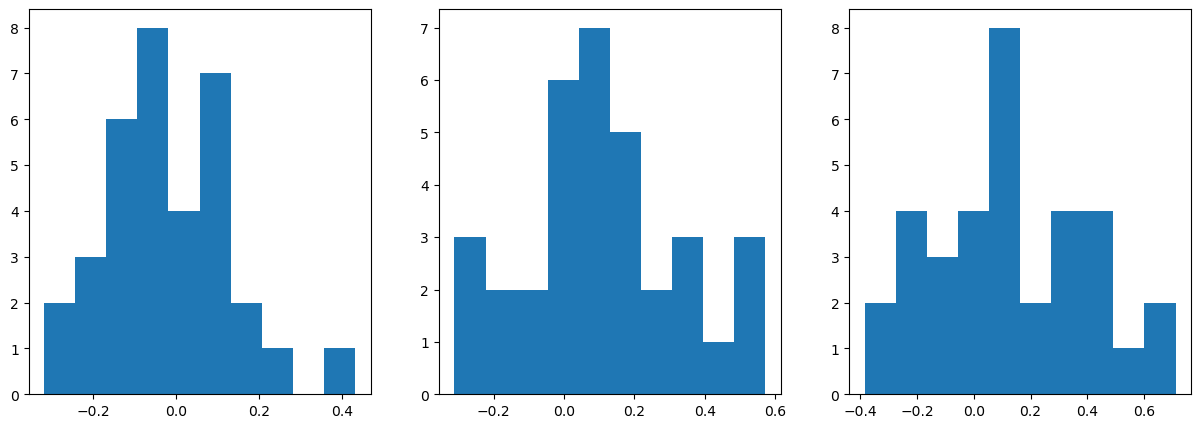

In [103]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.hist(corr_data_cf)
plt.subplot(1,3,2);plt.hist(corr_resid_cf)
plt.subplot(1,3,3);plt.hist(np.array(corr_resid_cf)-np.array(corr_data_cf))

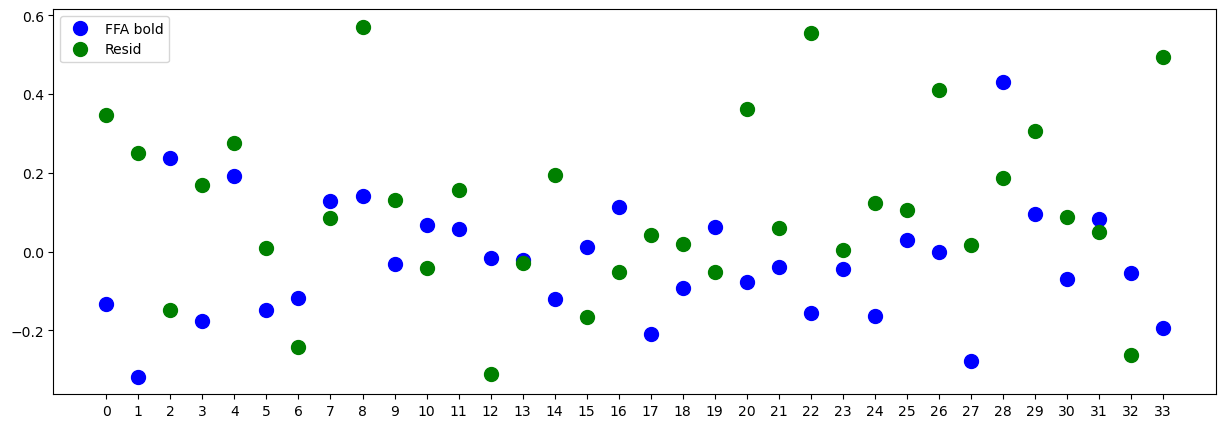

In [116]:
plt.figure(figsize=(15,5))
plt.plot(corr_data_cf,'b.',markersize=20)
plt.plot(corr_resid_cf,'g.',markersize=20)
plt.xticks(np.arange(len(subs)));
plt.legend(['FFA bold','Resid'])

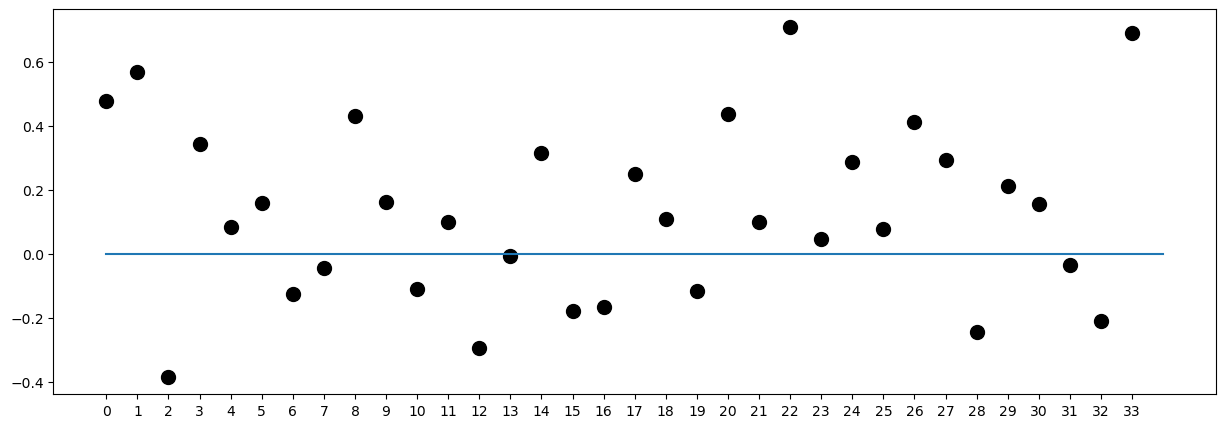

In [113]:
plt.figure(figsize=(15,5))
plt.plot(corr_resid_cf-corr_data_cf,'k.',markersize=20)
plt.plot([0,34],[0,0])
plt.xticks(np.arange(len(subs)));

In [125]:
[corr_resid_cf.mean(),corr_data_cf.mean()]

[0.10923301417766987, -0.023780271566549573]

([<matplotlib.axis.XTick at 0x1554d7f82160>,
 [Text(0, 0, 'Resid'), Text(1, 0, 'FFA bold')])

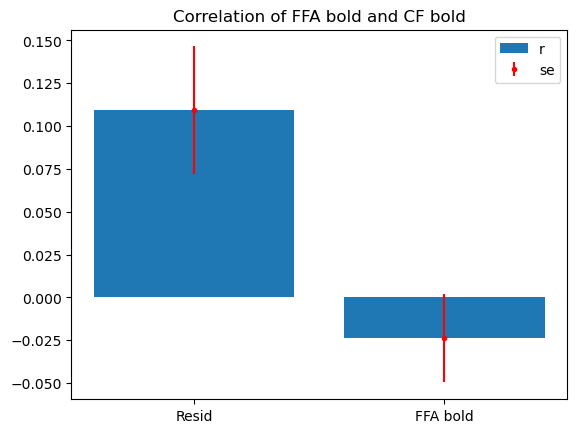

In [124]:
plt.bar([0,1],[corr_resid_cf.mean(),corr_data_cf.mean()])
plt.errorbar([0,1],[corr_resid_cf.mean(),corr_data_cf.mean()],[corr_resid_cf.std()/np.sqrt(len(corr_resid_cf)),corr_data_cf.std()/np.sqrt(len(corr_resid_cf))],fmt='r.');
plt.legend(['r','se'])
plt.title('Correlation of FFA bold and CF bold')
plt.xticks([0,1],['Resid','FFA bold'])

In [94]:
mot_vec = []
for s in tqdm(range(34)):
    sub = subs[s]
    mot_fn = f'../Data/020-fmriprepped/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv'
    mot = pd.read_csv(mot_fn,delimiter='\t')
    mot_outliers = mot['framewise_displacement'].values>.2
    mot_outliers = np.vstack((mot_outliers,np.hstack((False,mot_outliers[0:-1])),np.hstack((mot_outliers[1::],False)))).sum(axis=0)>0
    mot_vec.append( mot_outliers.sum() )
#outlier_idx = np.nonzero(mot_outliers)[0]

100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 71.62it/s]


In [107]:
mot_vec = np.array(mot_vec)

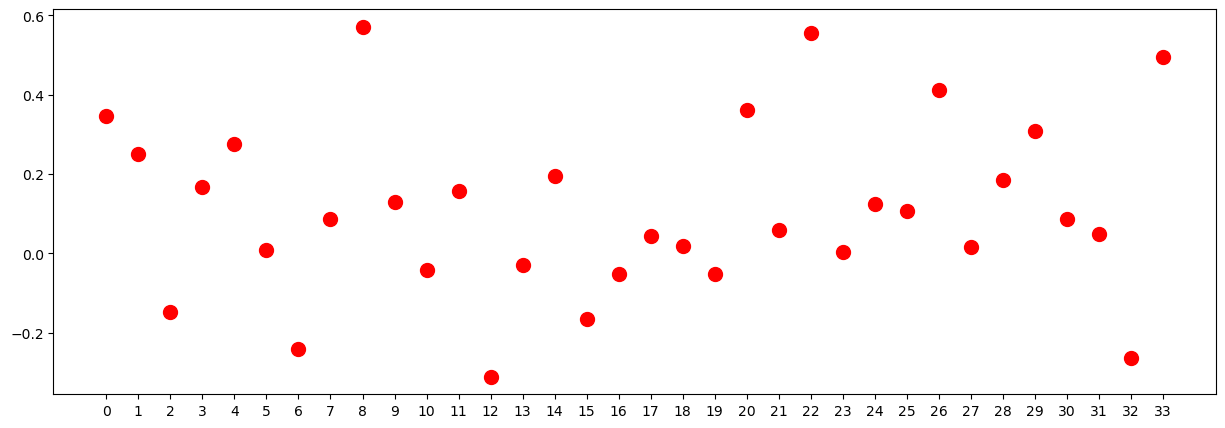

In [100]:
plt.figure(figsize=(15,5))
plt.plot(corr_resid_cf,'r.',markersize=20)
plt.xticks(np.arange(len(subs)));

In [129]:
np.corrcoef(corr_data_cf,mot_vec)[0,1]

0.027863245416263383

In [130]:
np.corrcoef(corr_resid_cf,mot_vec)[0,1]

0.3535181138302018

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn import linear_model

# cf_for_compcorr = ants.image_read(os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF.nii').format(sub=sub,r=r))

# cf_pcs = PCA(n_components=5).fit_transform(epi_flat[cf_for_compcorr.numpy().flatten()==1,:].transpose())

# lin_reg = linear_model.LinearRegression()
# lin_reg.fit(cf_pcs,epi_flat[gm_flat==1,:].transpose());

# predicted = lin_reg.predict(cf_pcs)
# residuals = epi_flat[gm_flat==1,:].transpose()-predicted
# plt.plot(epi_flat[gm_flat==1,:].mean(axis=0)-epi_flat[gm_flat==1,:].mean(axis=0).mean())
# epi_flat[gm_flat==1,:]=residuals.transpose()
# plt.plot(epi_flat[gm_flat==1,:].mean(axis=0)-epi_flat[gm_flat==1,:].mean(axis=0).mean())